In [11]:
import sys

sys.path.append("..")
from trading.system import *
from trading.agents import *

In [15]:
# from system import *
# from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from matplotlib import rcParams
import os
from tqdm import tqdm

In [16]:
sns.set('paper')

# Generating Experimental Data

In [4]:
os.path.isfile('./training_history.csv')

True

In [5]:
if not os.path.isfile('./training_history.csv'):
    training_history = pd.DataFrame()
    N_EPISODES = 50
    with open("filtered_tickers.txt", "r") as src:
        filtered_tickers = src.read().split("\n")
    N_TICKERS = 30
    agents = [A2C, DDPG, DQN, ModelBased_NoText_Agent, ModelBasedAgent]
    for A in agents:
        for ticker in tqdm(filtered_tickers[0:N_TICKERS]):
            a = A()
            e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
            for i in range(N_EPISODES):
                h_train = a.run_episode(e_train)
    #             h_train['mode'] = 'train'
                h_train['t'] = range(len(h_train))
                h_train['episode'] = int(i + 1)
                h_train['agent'] = a.name
                training_history = pd.concat([training_history, h_train])
    training_history.to_csv('training_history.csv', index=False)
else:
    training_history = pd.read_csv('./training_history.csv')
    training_history['date'] = pd.to_datetime(training_history['date'])

In [6]:
training_history = training_history.sort_values(['agent', 'ticker', 'episode'])

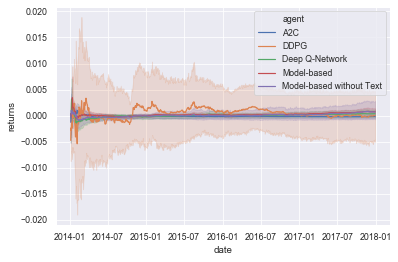

In [7]:
# training_history = training_history.sort_values('agent')
sns.lineplot('date', 'returns', data=training_history[training_history.episode == 1], hue='agent')

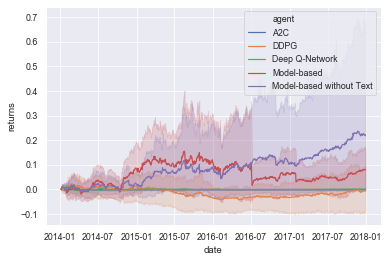

In [28]:
sns.lineplot('date', 'returns',
             data=training_history[training_history.episode == 10],
             hue='agent')

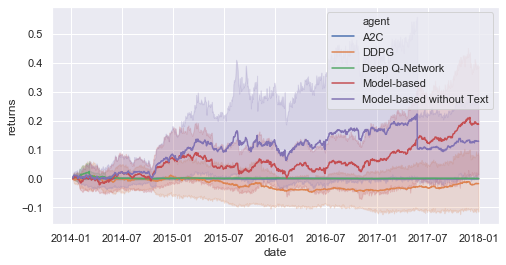

In [156]:
sns.lineplot('date', 'returns', data=training_history[training_history.episode == 50], hue='agent')

In [253]:
# training_history = total_history[(total_history['mode'] == 'train')]
training_history['discounted_reward'] = (training_history.t
                                             .apply( lambda x : np.power(a.gamma, x))
                                            * training_history.rewards)
rewards_df = (
    training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'})
        .groupby(['agent', 'episode'])
        .agg({'discounted_reward' : 'mean'})
#          .plot()
)

# total_history[(total_history.ticker == 'A') & (total_history['mode'] == 'train')]
# h = total_history
# h[h.mode == 'train']

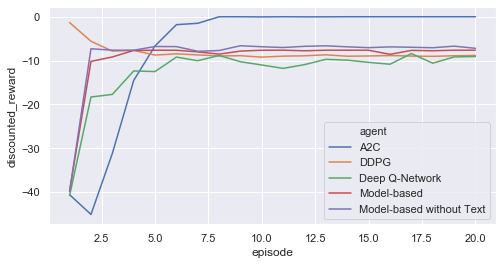

In [150]:
sns.set()
h = rewards_df.reset_index()
sns.lineplot('episode', 'discounted_reward', data=h[h.episode <= 20], hue='agent')

In [7]:
# rewards_df.reset_index(['agent', 'episode'], drop=False)

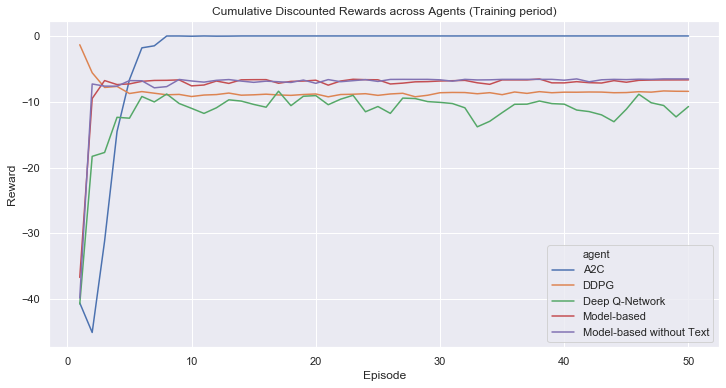

In [254]:
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=rewards_df.reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

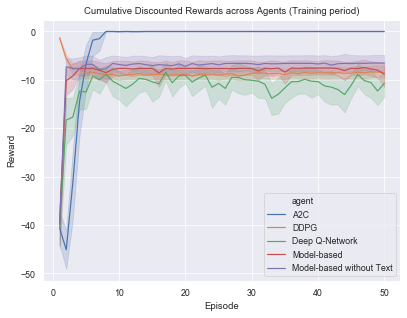

In [389]:
sns.set('paper')
rcParams['figure.figsize'] = (6.4, 4.8)
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=(training_history
                     .groupby(['agent', 'ticker', 'episode'])
                  )
        .agg({'discounted_reward' : 'sum'}).reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.savefig('../plots/rewards-all-agents.svg')
plt.show()

In [8]:
test_history = pd.DataFrame()
if not os.path.isfile('./test_history.csv'):
    with open("filtered_tickers.txt", "r") as src:
        filtered_tickers = src.read().split("\n")

    agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
    # agents = [DQN, A2C, DDPG, ModelBasedAgent]
    for A in agents:
        for i, ticker in tqdm(enumerate(filtered_tickers)):
            a = A()
            e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')

            for i in range(1):
                h_train = a.run_episode(e_train)

            e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
            h_test = a.run_episode(e_test)
            h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
            h_test['agent'] = a.name
            test_history = pd.concat([test_history, h_test])
            if i == 0:
                test_history.to_csv('test_history.csv', index=False)
            elif i % 10 == 0:
                 test_history.to_csv('test_history.csv', mode='a', header=False, index=False)
else:
    test_history = pd.read_csv('test_history.csv')
    test_history['date'] = pd.to_datetime(test_history['date'])

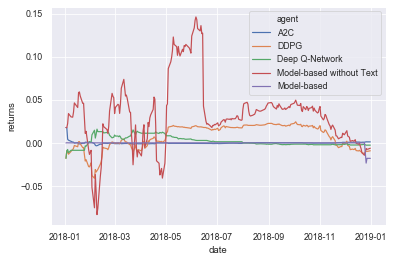

In [8]:
sns.lineplot('date', 'returns', data=test_history[test_history['ticker'] == 'AAPL'],
            hue='agent')

In [17]:
test_history.dtypes

date       datetime64[ns]
ticker             object
rewards           float64
actions           float64
returns           float64
prices            float64
t                   int64
agent              object
dtype: object

In [244]:
test_history = test_history.sort_values(['agent', 'ticker', 'date'])

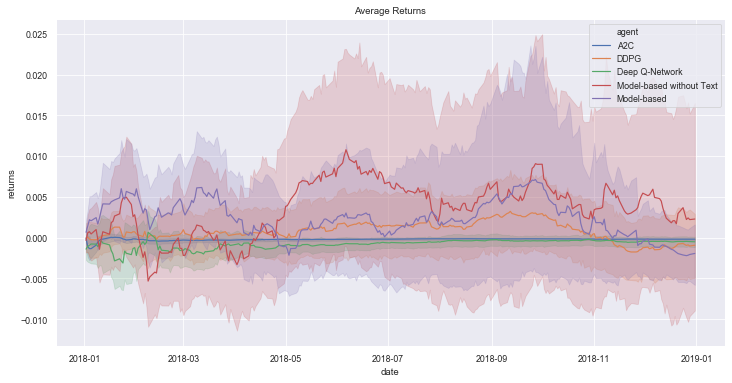

In [388]:
rcParams['figure.figsize'] = (12, 6)
plt.gcf().clear()
fig = plt.figure(1)

ax = sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief',)
ax.set_title('Average Returns')
ax.grid('on')

# fig.savefig('../plots/average-returns-all.svg')
fig.savefig('../plots/average-returns-all.svg')

In [105]:
# sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief')
# plt.title('Average Returns')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('../plots/average-returns-all.svg')

In [18]:
test_history.columns

Index(['date', 'ticker', 'rewards', 'actions', 'returns', 'prices', 'mode',
       't', 'episode', 'agent'],
      dtype='object')

# Volatility in Test Set Performance

,ticker,rewards,actions,returns,prices,t,agent
date,,,,,,,
2018-01-02,A,-10.095072,-1.0,-0.009406,67.599998,1005,A2C
2018-01-03,A,-9.906919,0.0,-0.004725,69.320000,1006,A2C
2018-01-04,A,-9.832611,-1.0,-0.000663,68.800003,1007,A2C
2018-01-05,A,-0.159568,-1.0,-0.006015,69.900002,1008,A2C
2018-01-08,A,-9.821651,0.0,-0.004524,70.050003,1009,A2C
...,...,...,...,...,...,...,...
2018-12-24,ZTS,-0.326440,1.0,0.023568,79.279999,1251,Model-based
2018-12-26,ZTS,0.495101,1.0,0.038462,82.919998,1252,Model-based
2018-12-27,ZTS,0.191784,1.0,0.044232,84.330002,1253,Model-based


In [61]:
test_vol_history = (test_history.set_index('date')
                        .groupby(['agent', 'ticker'])['returns']
                        .rolling(14).std()
                        .reset_index())
# test_history.groupby(['agent'])['date'].head(10).sort_values()

In [62]:
test_vol_history

,agent,ticker,date,returns
0,A2C,A,2018-01-02,NaN
1,A2C,A,2018-01-03,NaN
2,A2C,A,2018-01-04,NaN
3,A2C,A,2018-01-05,NaN
4,A2C,A,2018-01-08,NaN
...,...,...,...,...
484425,Model-based without Text,ZTS,2018-12-24,0.035221
484426,Model-based without Text,ZTS,2018-12-26,0.034756
484427,Model-based without Text,ZTS,2018-12-27,0.033242
484428,Model-based without Text,ZTS,2018-12-28,0.032758


In [55]:
test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).mean()
# test_vol_history = test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).mean()
# test_vol_history

agent                     ticker        
A2C                       A       0              NaN
                                  1              NaN
                                  2              NaN
                                  3              NaN
                                  4              NaN
                                              ...   
Model-based without Text  ZTS     387539   -0.208474
                                  387540   -0.203879
                                  387541   -0.200380
                                  387542   -0.198382
                                  387543   -0.196576
Name: returns, Length: 484430, dtype: float64

In [52]:
# test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).std()

In [54]:
test_vol_history

,agent,ticker,returns
0,A2C,A,NaN
1,A2C,A,NaN
2,A2C,A,NaN
3,A2C,A,NaN
4,A2C,A,NaN
...,...,...,...
484425,Model-based without Text,ZTS,0.035221
484426,Model-based without Text,ZTS,0.034756
484427,Model-based without Text,ZTS,0.033242
484428,Model-based without Text,ZTS,0.032758


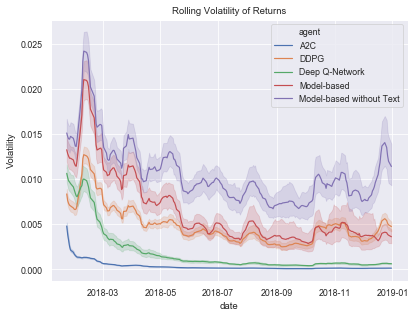

In [390]:

rcParams['figure.figsize'] = (6.4, 4.8)
sns.lineplot('date', 'returns', data=test_vol_history, hue='agent', legend='brief')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Volatility')
plt.title('Rolling Volatility of Returns')
plt.savefig('../plots/volatility-all.svg')
plt.savefig('../plots/volatility-all.png')


In [71]:
test_history.groupby(['agent', 'ticker'])[['returns', 'prices']].rolling(14).apply(sharpe)

returns    prices
agent                    ticker date                          
A2C                      A      2018-01-02       NaN       NaN
                                2018-01-03       NaN       NaN
                                2018-01-04       NaN       NaN
                                2018-01-05       NaN       NaN
                                2018-01-08       NaN       NaN
...                                              ...       ...
Model-based without Text ZTS    2018-12-24 -1.581932  5.946621
                                2018-12-26 -1.567752  5.968785
                                2018-12-27 -1.611015  6.212253
                                2018-12-28 -1.618528  6.275557
                                2018-12-31 -1.658865  6.494740

[484430 rows x 2 columns]

In [64]:
def sharpe(y):
    return (y.mean() / (np.sqrt(14)*y.std() + 1e-6))

test_sharpe_history = test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).apply(sharpe).reset_index()


,agent,ticker,date,returns
60,A2C,A,2018-03-29,-2.975840
61,A2C,A,2018-04-02,-2.957913
62,A2C,A,2018-04-03,-2.934266
63,A2C,A,2018-04-04,-2.911028
64,A2C,A,2018-04-05,-2.912272
65,A2C,A,2018-04-06,-2.598557
66,A2C,A,2018-04-09,-2.618181
67,A2C,A,2018-04-10,-3.149895
68,A2C,A,2018-04-11,-4.017800
69,A2C,A,2018-04-12,-3.974721


In [68]:
test_sharpe_history.groupby('agent').max()

,ticker,date,returns
agent,,,
A2C,ZTS,2018-12-31,5655.940999
DDPG,ZTS,2018-12-31,111.837424
Deep Q-Network,ZTS,2018-12-31,52263.340397
Model-based,ZTS,2018-12-31,35329.795918
Model-based without Text,ZTS,2018-12-31,23029.508793


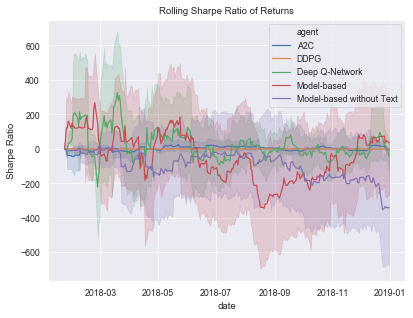

In [387]:
sns.lineplot('date', 'returns', data=test_sharpe_history, hue='agent')
rcParams['figure.figsize'] = (6.4, 4.8)
plt.ylabel('Sharpe Ratio')
plt.title('Rolling Sharpe Ratio of Returns')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.ylim((-20,20))
# plt.show()
plt.savefig('../plots/sharpe-all.svg')

In [174]:
test_history[test_history.agent != 'DDPG'].groupby(['agent', 'actions'])['returns'].median()
# sns.catplot(x='actions', y='returns',
#             hue='agent', kind='box', data=test_history)

agent                     actions
A2C                       -1.0      -0.000154
                           0.0      -0.000148
                           1.0      -0.000227
Deep Q-Network            -1.0      -0.000658
                           0.0       0.000000
                           1.0      -0.000141
Model-based               -1.0      -0.003830
                           0.0       0.000000
                           1.0       0.003183
Model-based without Text  -1.0      -0.013863
                           0.0       0.000000
                           1.0       0.003176
Name: returns, dtype: float64

In [177]:
test_history[test_history.agent != 'DDPG'].groupby(['agent', 'actions'])['returns'].max()

agent                     actions
A2C                       -1.0       0.161867
                           0.0       0.021654
                           1.0       0.064193
Deep Q-Network            -1.0       0.189507
                           0.0       0.076091
                           1.0       0.190209
Model-based               -1.0       0.546925
                           0.0       0.209946
                           1.0       1.112272
Model-based without Text  -1.0       1.665119
                           0.0       0.222164
                           1.0       1.399679
Name: returns, dtype: float64

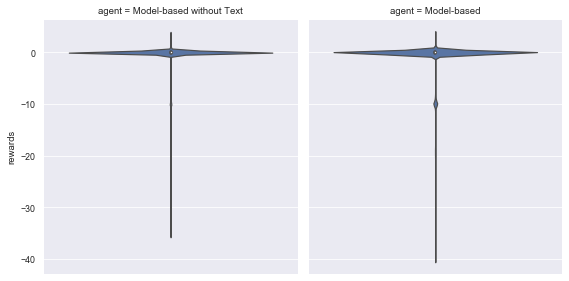

In [74]:
sns.catplot(data=test_history[test_history.agent.isin(['Model-based', 
                                                        'Model-based without Text'])],
           y="rewards", col="agent", kind="violin",
           height=4, aspect=1)

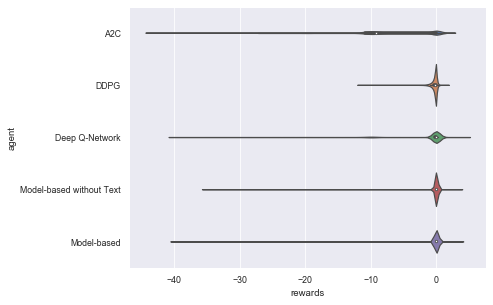

In [118]:
sns.violinplot(data=test_history,
           x="rewards", y='agent')

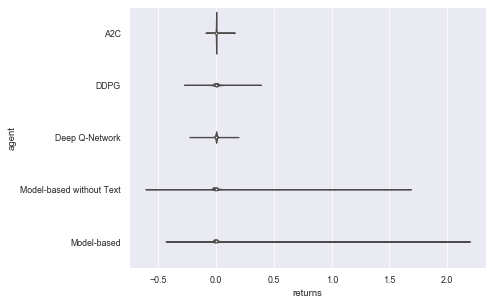

In [116]:
rcParams['figure.figsize'] = (6.4, 4.8)
sns.violinplot(data=test_history,
               x="returns", y='agent')

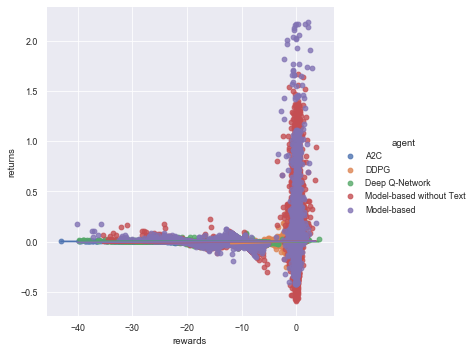

In [120]:
sns.lmplot(data=test_history,
             x="rewards", y='returns', hue='agent')

TypeError: distplot() got an unexpected keyword argument 'aspect'

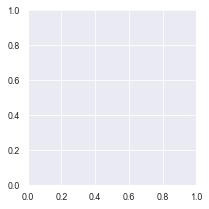

In [106]:
rcParams['figure.figsize'] = (2*6.4, 4.8)
q = sns.FacetGrid(data=test_history, hue='agent')
q.map(sns.distplot, 'returns', aspect=1.61)

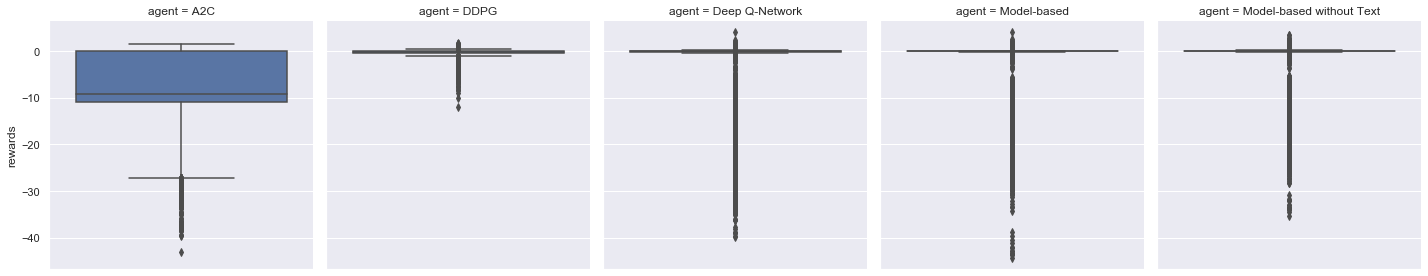

In [203]:
sns.catplot(data=test_history, y="rewards", col="agent",
            kind="box", height=4, aspect=1)

In [122]:
x = test_history[test_history.agent == 'Model-based without Text'].returns
y = test_history[test_history.agent == 'Model-based'].returns
len(x), len(y)

(96886, 96886)

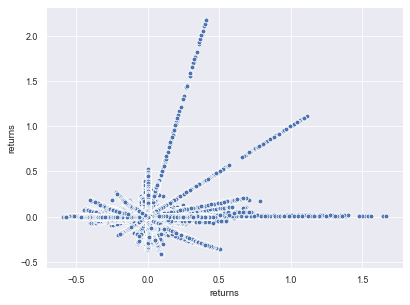

In [128]:
sns.scatterplot(x,y)

In [131]:
(test_history[test_history.agent.isin(['Model-based', 'Model-based without Text'])]
 .reset_index('date', drop=True)   
 .groupby('date'))

1

In [156]:
class RandomAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.name = "Random"
        
    def run_episode(self, environment):
        _ = environment.reset()
        done = False
        while not done:
            random_position = np.random.randint(-1, 1+1)
            _, __, done, ___ = environment.step(random_position)
        return environment.close()

In [145]:
r = RandomAgent()
r.train()

100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


In [146]:
r.history

,date,ticker,rewards,actions,returns,prices,episode,t
0,2014-01-06,A,0.000000,0,0.000000,40.515022,1,0
1,2014-01-07,A,-10.144008,-1,-0.014299,41.094421,1,1
2,2014-01-08,A,-9.857977,0,-0.007201,41.766811,1,2
3,2014-01-09,A,-9.854601,1,-0.004699,41.781116,1,3
4,2014-01-10,A,0.087783,1,-0.001745,42.153076,1,4
...,...,...,...,...,...,...,...,...
20095,2017-12-22,AAPL,-12.594364,1,-0.000487,175.009995,5,1000
20096,2017-12-26,AAPL,-0.159743,1,-0.000508,170.570007,5,1001
20097,2017-12-27,AAPL,-6.137423,0,-0.000508,170.600006,5,1002
20098,2017-12-28,AAPL,-6.154689,-1,-0.000509,171.080002,5,1003


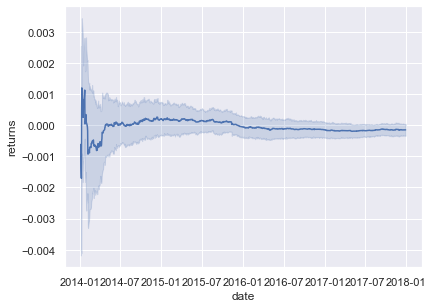

In [154]:
sns.lineplot(data=r.history, x='date', y='returns')

In [168]:
random_history = pd.DataFrame()
if not os.path.isfile('./random_history.csv'):
    with open("filtered_tickers.txt", "r") as src:
        filtered_tickers = src.read().split("\n")

    for ticker in (filtered_tickers):
        a = RandomAgent()
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        h_test = a.run_episode(e_test)
        random_history = pd.concat([random_history, h_test])
else:
    random_history = pd.read_csv('random_history.csv')
    random_history['date'] = pd.to_datetime(random_history['date'])

In [170]:
random_history['agent'] = 'Random'
random_history

,date,ticker,rewards,actions,returns,prices,agent
Date,,,,,,,
2018-01-02,2018-01-02,A,-9.906928,1,0.009406,67.599998,Random
2018-01-03,2018-01-03,A,-10.095081,0,0.004681,69.320000,Random
2018-01-04,2018-01-04,A,-10.019361,-1,0.005624,68.800003,Random
2018-01-05,2018-01-05,A,-10.170808,0,0.004207,69.900002,Random
2018-01-08,2018-01-08,A,0.000000,0,0.004207,70.050003,Random
...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ZTS,-11.610136,-1,0.000940,79.279999,Random
2018-12-26,2018-12-26,ZTS,-0.565274,-1,0.000710,82.919998,Random
2018-12-27,2018-12-27,ZTS,-23.295664,1,0.000784,84.330002,Random


In [171]:
test_history

,date,ticker,rewards,actions,returns,prices,t,agent
date,,,,,,,,
2018-01-02,2018-01-02,A,-10.095072,-1.0,-0.009406,67.599998,1005,A2C
2018-01-03,2018-01-03,A,-9.906919,0.0,-0.004725,69.320000,1006,A2C
2018-01-04,2018-01-04,A,-9.832611,-1.0,-0.000663,68.800003,1007,A2C
2018-01-05,2018-01-05,A,-0.159568,-1.0,-0.006015,69.900002,1008,A2C
2018-01-08,2018-01-08,A,-9.821651,0.0,-0.004524,70.050003,1009,A2C
...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ZTS,-0.326440,1.0,0.023568,79.279999,1251,Model-based
2018-12-26,2018-12-26,ZTS,0.495101,1.0,0.038462,82.919998,1252,Model-based
2018-12-27,2018-12-27,ZTS,0.191784,1.0,0.044232,84.330002,1253,Model-based


In [172]:
full_history = pd.concat([test_history, random_history])

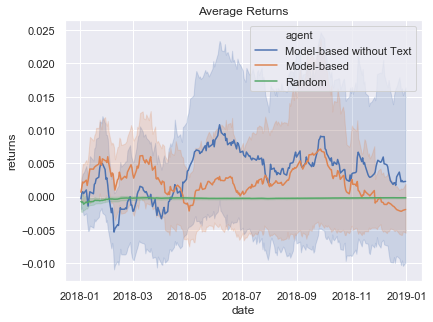

In [174]:
ax = sns.lineplot('date', 'returns', data=full_history[full_history.agent.isin(['Model-based',
                                                                               'Model-based without Text',
                                                                               'Random'])], hue='agent', legend='brief',)
ax.set_title('Average Returns')
ax.grid('on')


In [178]:
longonly_history = pd.DataFrame()
if not os.path.isfile('./longonly_history.csv'):
    with open("filtered_tickers.txt", "r") as src:
        filtered_tickers = src.read().split("\n")

    for ticker in (filtered_tickers):
        a = LongOnlyAgent()
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        h_test = a.run_episode(e_test)
        h_test['agent'] = 'Long-Only'
        longonly_history = pd.concat([longonly_history, h_test])
else:
    longonly_history = pd.read_csv('longonly_history.csv')
    longonly_history['date'] = pd.to_datetime(longonly_history['date'])

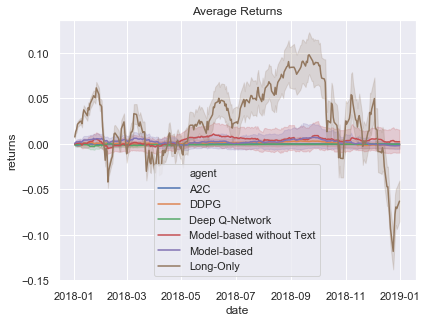

In [179]:
full_history = pd.concat([test_history, longonly_history])
ax = sns.lineplot('date', 'returns', data=full_history, hue='agent', legend='brief',)
ax.set_title('Average Returns')
ax.grid('on')

# Assessing Overfitting

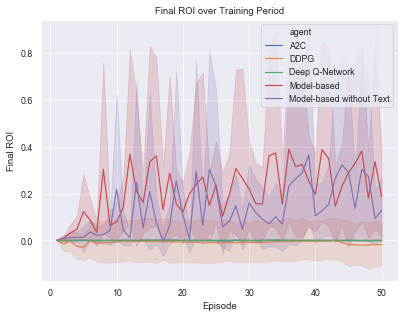

In [385]:
sns.lineplot(data=training_history[training_history.t == 1004],
            x='episode', y='returns', hue='agent')  # .groupby(['agent', 'ticker'])
plt.ylabel('Final ROI')
plt.xlabel('Episode')
plt.title('Final ROI over Training Period')
plt.savefig('../plots/roi-overfitting-plot.svg')

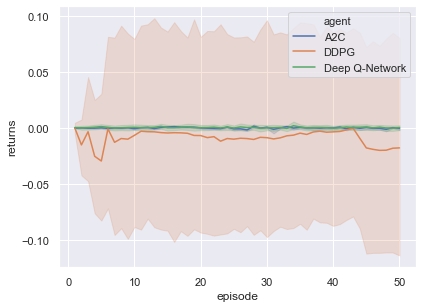

In [193]:
h = training_history[training_history.t == 1004]
h = h[~h.agent.isin(['Model-based', 'Model-based without Text'])]
sns.lineplot(data=h, x='episode', y='returns', hue='agent')  # .groupby(['agent', 'ticker'])

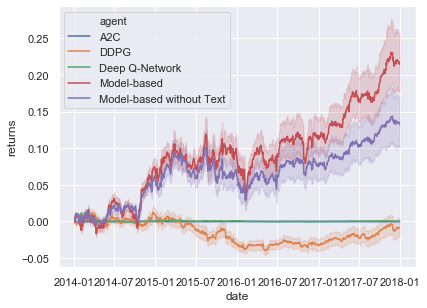

In [358]:
h = training_history # [training_history.t == 1004]
# h = h[h.agent.isin(['Model-based', 'Model-based without Text'])]
sns.lineplot(data=h, x='date', y='returns', hue='agent')  # .groupby(['agent', 'ticker'])

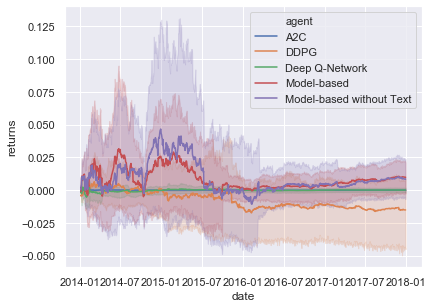

In [360]:
h = training_history[training_history.episode == 2] # [training_history.t == 1004]
# h = h[h.agent.isin(['Model-based', 'Model-based without Text'])]
sns.lineplot(data=h, x='date', y='returns', hue='agent')  # .groupby(['agent', 'ticker'])

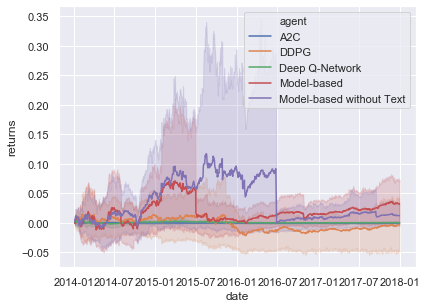

In [361]:
h = training_history[training_history.episode == 3] # [training_history.t == 1004]
# h = h[h.agent.isin(['Model-based', 'Model-based without Text'])]
sns.lineplot(data=h, x='date', y='returns', hue='agent')  # .groupby(['agent', 'ticker'])

In [365]:
training_history[training_history.episode <= 10]

,date,ticker,rewards,actions,returns,prices,t,episode,agent,discounted_reward
1507500,2014-01-06,A,0.000000,0.0,0.000000,40.515022,0,1,A2C,0.000000
1507501,2014-01-07,A,-9.857992,1.0,0.014299,41.094421,1,1,A2C,-7.886393
1507502,2014-01-08,A,-10.144023,0.0,0.007099,41.766811,2,1,A2C,-6.492175
1507503,2014-01-09,A,0.000000,0.0,0.007099,41.781116,3,1,A2C,0.000000
1507504,2014-01-10,A,0.000000,0.0,0.007099,42.153076,4,1,A2C,0.000000
...,...,...,...,...,...,...,...,...,...,...
5989795,2017-12-22,AMAT,0.000000,0.0,0.002858,52.060001,1000,10,Model-based without Text,0.000000
5989796,2017-12-26,AMAT,0.000000,0.0,0.002858,51.049999,1001,10,Model-based without Text,0.000000
5989797,2017-12-27,AMAT,0.000000,0.0,0.002858,51.680000,1002,10,Model-based without Text,0.000000
5989798,2017-12-28,AMAT,0.000000,0.0,0.002858,51.720001,1003,10,Model-based without Text,0.000000


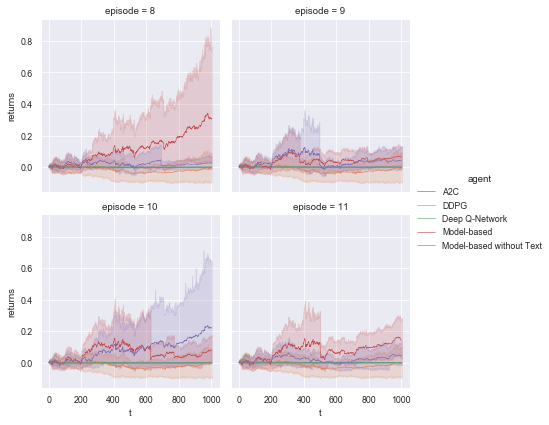

In [26]:
# h = training_history[training_history.ticker == 'AAPL']
h = training_history[training_history.episode.between(8, 11)]
# rcParams['figure.figsize'] = (6.4, 4.8)
# plt.figure(figsize=(6.4, 4.8))
q = sns.FacetGrid(data=h, col='episode', hue='agent', col_wrap=2)
p = q.map(sns.lineplot, 't', 'returns', size=2).add_legend();
# plt.savefig('../plots/training-overfitting-plot.png')
plt.savefig('../plots/training-overfitting-plot.svg')

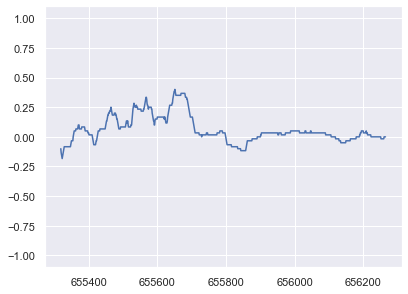

In [333]:
h = training_history[training_history.agent == 'Deep Q-Network']
h = h[h.ticker == 'ADS']
h = h[h.episode == 3]
plt.ylim((-1.1, 1.1))
h.actions.rolling(60).mean().plot()

In [203]:
training_history.agent.unique()

array(['A2C', 'DDPG', 'Deep Q-Network', 'Model-based',
       'Model-based without Text'], dtype=object)

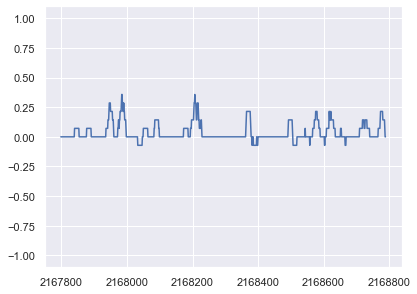

In [249]:
h = training_history[training_history.agent == 'A2C']
h = h[h.ticker == 'ADS']
h = h[h.episode == 8]
plt.ylim((-1.1, 1.1))
h.actions.rolling(14).mean().plot()

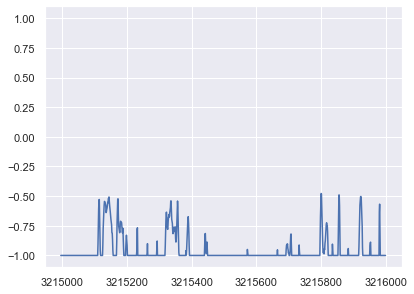

In [357]:
h = training_history[training_history.agent == 'DDPG']
h = h[h.ticker == 'AAPL']
h = h[h.episode == 50]
plt.ylim((-1.1, 1.1))
h.actions.plot()

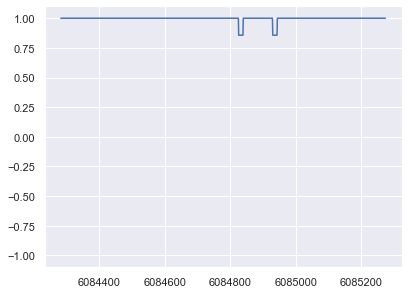

In [256]:
h = training_history[training_history.agent == 'Model-based']
h = h[h.ticker == 'AAL']
h = h[h.episode == 5]
plt.ylim((-1.1, 1.1))
h.actions.rolling(14).mean().plot()

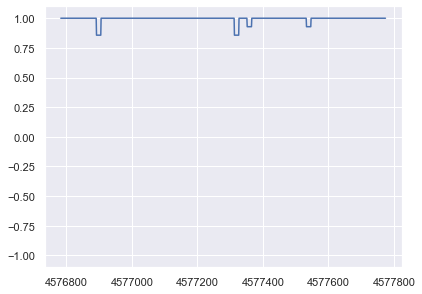

In [257]:
h = training_history[training_history.agent == 'Model-based without Text']
h = h[h.ticker == 'AAL']
h = h[h.episode == 5]
plt.ylim((-1.1, 1.1))
h.actions.rolling(14).mean().plot()

# Estimating the Optimal Action Distribution

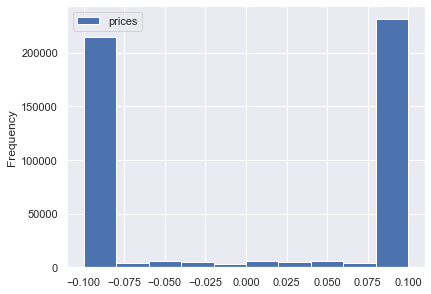

In [276]:
(test_history[['ticker', 'prices']]
    .groupby('ticker').diff()).clip(lower=-0.1, upper=0.1).plot(kind='hist')

In [292]:
test_history.ticker.unique()

array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN',
       'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES',
       'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALLE', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN',
       'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE',
       'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA',
       'BAC', 'BAX', 'BBY', 'BEN', 'BF-B', 'BIIB', 'BK', 'BKNG', 'BKR',
       'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX', 'BWA', 'BXP', 'C',
       'CAG', 'CAH', 'CAT', 'CB', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE',
       'CERN', 'CF', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX',
       'CMCSA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO',
       'COP', 'COST', 'COTY', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTL',
       'CTSH', 'CTXS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DHI',
       'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLTR', 'DOV', 'D

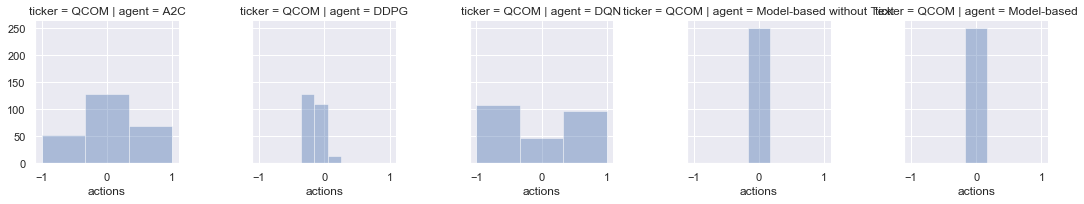

In [326]:
h = test_history[test_history.ticker.isin(['QCOM'])]
h.agent.replace(to_replace='Deep Q-Network', value='DQN', inplace=True)
# h = test_history
q = sns.FacetGrid(data=h, col='agent', row='ticker')
# sns.distplot('actions', hue='agent', data=h)
q.map(sns.distplot, 'actions', kde=False, bins=3, hist=True)

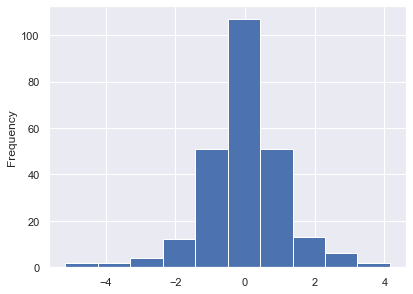

In [329]:
def clamp(x):
    boundary = 0.01
    if x < boundary:
        return 0
    return np.sign(x)

prices = h[h.agent == 'DQN'].prices
prices.diff().plot(kind='hist')
# prices.diff().apply(clamp).plot(kind='hist')


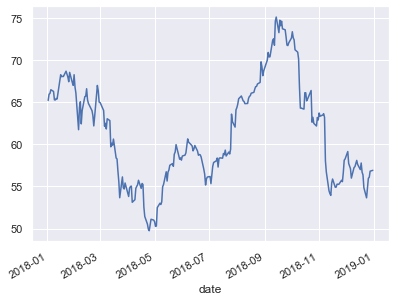

In [330]:
prices.plot()

In [487]:
s0 = TradingEnv().reset()
state_tensor = FloatTensor([s0] * 3)
print(state_tensor.shape)
x = state_tensor.reshape(-1, 14, 5).unsqueeze(1)
print(x.shape)

# l1 = torch.nn.Conv2d(1, 6, (5,3), padding=0)
l1 = nn.Conv2d(1, 6, (5,3), padding=0)
x = F.relu(l1(x))
print(x.shape)

l2 = nn.Conv2d(6, 12, (3,3), padding=0)
x = F.relu(l2(x))
print(x.shape)

l3 = nn.Conv2d(12, 28, (3,1), padding=0)
x = F.relu(l3(x))
print(x.shape)

l4 = nn.Linear(168, ACTION_DIM)
x = l4(x.reshape(-1, 168))
print(x.shape)

torch.Size([3, 70])
torch.Size([3, 1, 14, 5])
torch.Size([3, 6, 10, 3])
torch.Size([3, 12, 8, 1])
torch.Size([3, 28, 6, 1])
torch.Size([3, 3])


In [ ]:
torch.nn.

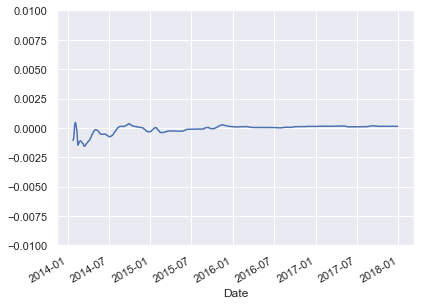

In [492]:
class DeeperQ(QNetwork):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 6, (5,3), padding=0)
        self.l2 = nn.Conv2d(6, 12, (3,3), padding=0)
        self.l3 = nn.Conv2d(12, 28, (3,1), padding=0)
        self.l4 = nn.Linear(168, 70)
        self.l4_dropout = nn.Dropout(0.1)
        self.l5 = nn.Linear(70, ACTION_DIM)

    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        assert not torch.isnan(x).any(), f"NaN in input {x}"
        x = x.reshape(-1, 14, 5).unsqueeze(1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x.reshape(-1, 168)))
        x = self.l4_dropout(x)
        x = F.relu(self.l5(x))
        return x

class DeeperQAgent(DQN):
    def __init__(self):
        super().__init__()
        self.model = DeeperQ()
        self.target = DeeperQ()
        if use_cuda:
            self.model.cuda()
            self.target.cuda()
        self.LR = 1e-8
        self.name = "Deeper Q-Network"
        self.optimizer = optim.Adam(self.model.parameters(), self.LR)

a = DeeperQAgent()
e = TradingEnv()
h = a.run_episode(e)
plt.ylim((-0.01, 0.01))
h['returns'].rolling(14).mean().plot()

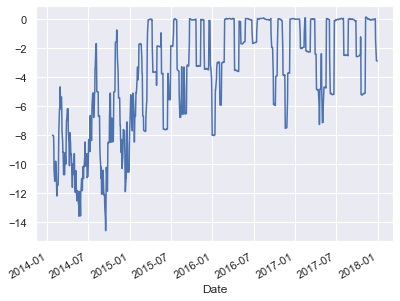

In [478]:
h['rewards'].rolling(14).mean().plot()

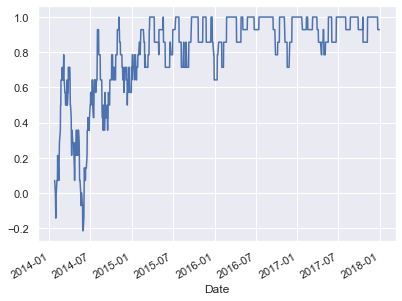

In [479]:
h['actions'].rolling(14).mean().plot()